In [1]:
from skimage.transform import rescale, resize

In [2]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
import time

In [5]:
import torch.nn. functional as F

In [6]:
import os

In [7]:
BATCH_SIZE=64
LR = 0.0001
EPOCHS = 20
DEVICE  = torch.device('cuda')

In [8]:
from PIL import Image

def grayscale_to_rgb(input_path, output_path):
    # Open the grayscale image
    grayscale_img = Image.open(input_path)
    
    # Convert grayscale to RGB
    rgb_img = grayscale_img.convert("RGB")
    
    # Save the RGB image
    rgb_img.save(output_path)

In [174]:
# Folder containing grayscale images
folder_path = "C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Testing/Six"

# Output folder for RGB images
output_folder = "C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Testing/Six"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):  # Add more extensions if needed
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        grayscale_to_rgb(input_path, output_path)

In [62]:
TRAIN_CSV_FILE=pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Training/Training_triplets.csv')
VALIDATION_CSV_FILE=pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Validation/Validation_triplets.csv')
DATA_DIR="C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Data_Comb/"

In [9]:
train_df=TRAIN_CSV_FILE
valid_df=VALIDATION_CSV_FILE

In [30]:
row = TRAIN_CSV_FILE.iloc[1]
img = io.imread(DATA_DIR+train_df.iloc[1][0])
img.shape

C:\Users\asingh74\AppData\Local\Temp\ipykernel_13304\2544285067.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = io.imread(DATA_DIR+train_df.iloc[1][0])


(28, 28, 3)

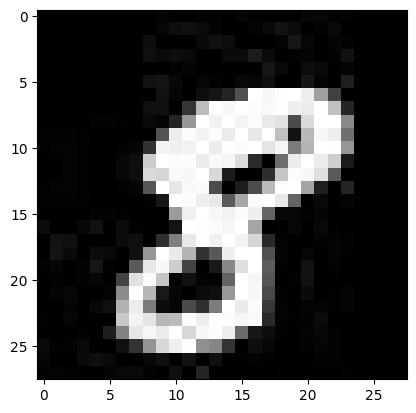

In [31]:
plt.imshow(img)

In [32]:
def std_mm(image, feature_range=(0, 1)):
  image = np.array(image)  # Convert to numpy array
  min_val = np.min(image)
  max_val = np.max(image)
  
  if min_val == max_val:
      return np.ones_like(image) * feature_range[0]  # Return all pixels at min range value
  
  scaled_image = (image - min_val) / (max_val - min_val)
  scaled_image = scaled_image * (feature_range[1] - feature_range[0]) + feature_range[0]
  return scaled_image.astype(image.dtype) 

In [33]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),         
    transforms.RandomHorizontalFlip(p=0.5)                       
])

In [34]:
class APN_Dataset (Dataset):
    
    def __init__(self, df):
        self.df= df
        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        A=io.imread(DATA_DIR+str(row.Anchor))
        A=torch.from_numpy(A).permute(2,0,1)/255.0
        A= train_transform(A)
        P=io.imread(DATA_DIR+str(row.Positive))
        P=torch.from_numpy(P).permute(2,0,1)/255.0
        P = train_transform(P)
        N=io.imread(DATA_DIR+str(row.Negative))
        N=torch.from_numpy(N).permute(2,0,1)/255.0
        N = train_transform(N)
        A=std_mm(A)
        P=std_mm(P)
        N=std_mm(N)
        return A, P, N

In [35]:
trainset=APN_Dataset(train_df)
validset=APN_Dataset(valid_df)
print("len of train set:", len(trainset))
print("len of valid set:", len(validset))

len of train set: 161100
len of valid set: 17700


In [36]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [37]:
print(f"No of batches in trainloader : {len(trainloader)}")
print(f"No of batches in vaildloader : {len(validloader)}")

No of batches in trainloader : 2518
No of batches in vaildloader : 277


In [35]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
       
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)  
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1) 
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)  
        self.fc3 = nn.Linear(84, 10)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.nn.functional.normalize(x, p=2.0, dim = 1)
        return x

model = LeNet5()
model = model.to(DEVICE)

print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [39]:
# Create Train and Eval function
def train_fn(model, dataloader, optimizer, criterion):
#     model.train() # ON Dropout
    total_loss = 0.0
    for A, P, N in tqdm(dataloader):
        optimizer.zero_grad() # remove previous gradient
        A=A.clone().detach()
        P=P.clone().detach()
        N=N.clone().detach()
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        loss = criterion(A_embs, P_embs, N_embs)
        
        loss.backward () # Back Propagation, compute gradients
        optimizer.step() # Update weights
        total_loss += loss.item ()
    return total_loss/len(dataloader)

In [40]:
def eval_fn(model, dataloader, criterion):
    model.eval() # ON Dropout
    total_loss = 0.0
    with torch.no_grad():
                for A, P, N in tqdm(validloader):
                    A=A.clone().detach()
                    P=P.clone().detach()
                    N=N.clone().detach()
                    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
                    A_embs = model(A)
                    P_embs = model(P)
                    N_embs = model(N)
                    loss = criterion(A_embs, P_embs, N_embs)
                    total_loss += loss.item ()
    return total_loss/len(dataloader)

In [41]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)
criterion=nn.TripletMarginLoss()

In [42]:
# Training Loop
t_loss=[]
v_loss=[]
best_valid_loss=np.Inf
print("BVL", best_valid_loss)
for i in range (EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss= eval_fn(model, validloader, criterion)
    t_loss.append(train_loss)
    v_loss.append(valid_loss)
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'MNIST_Model_Final.pt')
        best_valid_loss =valid_loss
        print("SAVED WEIGHTS SUCCESS")
    print (f" EPOCHS: {i+1} train loss: {train_loss} valid_loss: {valid_loss} ")


BVL inf


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:15<00:00,  2.05it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 1 train loss: 0.3019012999976079 valid_loss: 0.20724386235342668 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:14<00:00,  2.06it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 2 train loss: 0.16003106613188534 valid_loss: 0.16152775759677596 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:11<00:00,  2.11it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 3 train loss: 0.10634073720485966 valid_loss: 0.13397299312727545 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:10<00:00,  2.12it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 4 train loss: 0.072474696482602 valid_loss: 0.1233764208436335 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:22<00:00,  1.95it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 5 train loss: 0.047796776320347366 valid_loss: 0.1029130665229008 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:01<00:00,  1.15it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 6 train loss: 0.030011468842504302 valid_loss: 0.09894703334661382 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:12<00:00,  2.09it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 7 train loss: 0.01870426768621961 valid_loss: 0.09370652400629616 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:12<00:00,  2.09it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 8 train loss: 0.012013233003426252 valid_loss: 0.09168413513598943 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:48<00:00,  1.21it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 9 train loss: 0.00816581030121048 valid_loss: 0.08891217359795575 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:44<00:00,  1.23it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 10 train loss: 0.005742879084372823 valid_loss: 0.08139216794635737 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:13<00:00,  2.08it/s]


 EPOCHS: 11 train loss: 0.004173874524381305 valid_loss: 0.08650062335083523 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:12<00:00,  2.09it/s]


SAVED WEIGHTS SUCCESS
 EPOCHS: 12 train loss: 0.0029477476222977647 valid_loss: 0.0797611576595784 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [02:14<00:00,  2.06it/s]


 EPOCHS: 13 train loss: 0.002695302977548458 valid_loss: 0.08488883946661141 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:48<00:00,  1.21it/s]


 EPOCHS: 14 train loss: 0.0018595731402935964 valid_loss: 0.08418751571542626 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [01:17<00:00,  3.57it/s]


 EPOCHS: 15 train loss: 0.0018814987039919929 valid_loss: 0.0839408482273617 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [01:16<00:00,  3.62it/s]


 EPOCHS: 16 train loss: 0.001462128450184161 valid_loss: 0.07984237755238606 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [01:17<00:00,  3.56it/s]


 EPOCHS: 17 train loss: 0.0012230231852741872 valid_loss: 0.08400420716792237 


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [01:20<00:00,  3.44it/s]


 EPOCHS: 18 train loss: 0.001066912380228377 valid_loss: 0.0899816608823002 


 16%|████████████▍                                                                  | 398/2518 [02:08<11:25,  3.09it/s]


KeyboardInterrupt: 

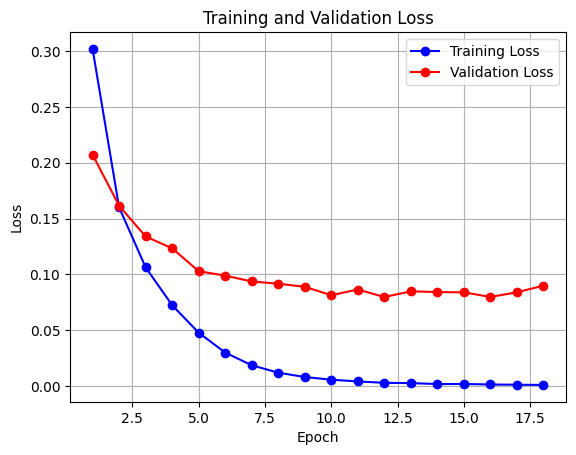

In [43]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays containing training and validation loss values for each epoch
    # Example validation loss values

epochs = range(1, len(t_loss) + 1)
plt.plot(epochs, t_loss, 'bo-', label='Training Loss')
plt.plot(epochs, v_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr =np.array(anc_img_names)
    #print("A shape", anc_img_names_arr)
    encodings = []
    model.eval()
    with torch.no_grad() :
        for i in tqdm (anc_img_names_arr):
            A = io.imread(DATA_DIR+i)
            A= torch.from_numpy(A).permute (2,0,1)/ 255.0
            A=A.to(DEVICE)
            print("A.unsqueeze (0)", A.unsqueeze(0).shape)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        encodings=np.array(encodings)
        encodings=pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)
    return df_enc

In [113]:
import os
def get_file_names_in_folder(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

def get_folder_names_in_folder(folder_path):
    folder_names = []
    # List all items in the folder
    for item_name in os.listdir(folder_path):
        # Check if the path is a directory
        if os.path.isdir(os.path.join(folder_path, item_name)):
            folder_names.append(item_name)
    return folder_names

folder_path = r'C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Training'
folder_names = get_folder_names_in_folder(folder_path)

dir=[]
for folder_name in folder_names:
    dir.append(folder_name)
    
files=[]
celebs = len(dir)
for i in range(0, celebs):
    file_path = folder_path+"/"+dir[i]
    file=get_file_names_in_folder(file_path)
    for f in file:
        files.append(f)
print(len(files))

1800


In [114]:
df=pd.DataFrame(files, columns=['Images'])

In [115]:
model.load_state_dict(torch.load('MNIST_Model_Final.pt'))
df_enc=get_encoding_csv(model,df['Images'])

  0%|                                                                                         | 0/1800 [00:00<?, ?it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  1%|▋                                                                               | 15/1800 [00:01<02:30, 11.87it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

  2%|█▊                                                                              | 41/1800 [00:01<00:47, 36.77it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

  4%|██▉                                                                             | 67/1800 [00:02<00:26, 64.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

  5%|████▏                                                                           | 93/1800 [00:02<00:19, 89.23it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

  7%|█████▏                                                                        | 119/1800 [00:02<00:15, 106.91it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

  8%|██████▎                                                                       | 145/1800 [00:02<00:14, 117.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 10%|███████▍                                                                      | 171/1800 [00:02<00:13, 118.14it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 11%|████████▌                                                                     | 197/1800 [00:03<00:12, 123.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 12%|█████████▋                                                                    | 223/1800 [00:03<00:12, 126.62it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 14%|██████████▊                                                                   | 249/1800 [00:03<00:12, 120.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 15%|███████████▉                                                                  | 275/1800 [00:03<00:12, 123.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 17%|█████████████                                                                 | 302/1800 [00:04<00:12, 124.02it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 19%|██████████████▊                                                               | 342/1800 [00:04<00:11, 128.99it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 20%|███████████████▉                                                              | 368/1800 [00:04<00:11, 129.26it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 21%|████████████████▌                                                             | 381/1800 [00:04<00:11, 125.53it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 23%|█████████████████▋                                                            | 409/1800 [00:04<00:10, 131.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 24%|██████████████████▉                                                           | 436/1800 [00:05<00:10, 125.52it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 26%|████████████████████                                                          | 462/1800 [00:05<00:10, 127.51it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 27%|█████████████████████▏                                                        | 488/1800 [00:05<00:10, 128.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 29%|██████████████████████▉                                                       | 528/1800 [00:05<00:09, 127.86it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 31%|████████████████████████                                                      | 555/1800 [00:05<00:09, 131.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 32%|████████████████████████▋                                                     | 569/1800 [00:06<00:09, 134.02it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 33%|█████████████████████████▊                                                    | 597/1800 [00:06<00:09, 126.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 35%|██████████████████████████▉                                                   | 623/1800 [00:06<00:09, 128.13it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 36%|████████████████████████████▏                                                 | 650/1800 [00:06<00:09, 125.87it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 38%|█████████████████████████████▍                                                | 678/1800 [00:06<00:08, 127.80it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 39%|██████████████████████████████▌                                               | 706/1800 [00:07<00:08, 128.74it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 41%|███████████████████████████████▋                                              | 732/1800 [00:07<00:08, 127.39it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 42%|████████████████████████████████▊                                             | 758/1800 [00:07<00:08, 128.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 44%|█████████████████████████████████▉                                            | 784/1800 [00:07<00:07, 129.09it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 45%|███████████████████████████████████                                           | 810/1800 [00:07<00:07, 129.46it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 46%|████████████████████████████████████▏                                         | 836/1800 [00:08<00:07, 129.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 48%|█████████████████████████████████████▎                                        | 862/1800 [00:08<00:07, 129.52it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 49%|██████████████████████████████████████▍                                       | 888/1800 [00:08<00:07, 123.67it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 51%|███████████████████████████████████████▋                                      | 915/1800 [00:08<00:06, 129.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 52%|████████████████████████████████████████▊                                     | 941/1800 [00:08<00:06, 129.60it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 54%|█████████████████████████████████████████▉                                    | 967/1800 [00:09<00:06, 129.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 56%|███████████████████████████████████████████                                  | 1006/1800 [00:09<00:06, 129.55it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 57%|███████████████████████████████████████████▌                                 | 1019/1800 [00:09<00:06, 122.71it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 58%|████████████████████████████████████████████▋                                | 1046/1800 [00:09<00:06, 125.04it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 60%|█████████████████████████████████████████████▉                               | 1074/1800 [00:10<00:05, 127.42it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 61%|███████████████████████████████████████████████                              | 1100/1800 [00:10<00:05, 123.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 63%|████████████████████████████████████████████████▊                            | 1140/1800 [00:10<00:05, 130.25it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 64%|█████████████████████████████████████████████████▎                           | 1154/1800 [00:10<00:05, 129.05it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 66%|██████████████████████████████████████████████████▍                          | 1180/1800 [00:10<00:04, 125.81it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 67%|███████████████████████████████████████████████████▌                         | 1206/1800 [00:11<00:04, 127.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 68%|████████████████████████████████████████████████████▋                        | 1232/1800 [00:11<00:04, 128.64it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 70%|█████████████████████████████████████████████████████▊                       | 1258/1800 [00:11<00:04, 123.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 71%|██████████████████████████████████████████████████████▉                      | 1285/1800 [00:11<00:04, 124.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 73%|████████████████████████████████████████████████████████                     | 1311/1800 [00:11<00:03, 127.24it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 75%|█████████████████████████████████████████████████████████▊                   | 1350/1800 [00:12<00:03, 128.79it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 76%|██████████████████████████████████████████████████████████▊                  | 1376/1800 [00:12<00:03, 129.17it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 77%|███████████████████████████████████████████████████████████▍                 | 1389/1800 [00:12<00:03, 129.28it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 79%|████████████████████████████████████████████████████████████▌                | 1417/1800 [00:12<00:02, 129.75it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 80%|█████████████████████████████████████████████████████████████▋               | 1443/1800 [00:12<00:02, 129.66it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 82%|██████████████████████████████████████████████████████████████▉              | 1471/1800 [00:13<00:02, 129.69it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 83%|████████████████████████████████████████████████████████████████▏            | 1500/1800 [00:13<00:02, 132.53it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 85%|█████████████████████████████████████████████████████████████████▎           | 1528/1800 [00:13<00:02, 131.78it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 86%|██████████████████████████████████████████████████████████████████▌          | 1556/1800 [00:13<00:01, 133.94it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 88%|███████████████████████████████████████████████████████████████████▊         | 1584/1800 [00:13<00:01, 132.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 90%|████████████████████████████████████████████████████████████████████▉        | 1611/1800 [00:14<00:01, 113.90it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 91%|██████████████████████████████████████████████████████████████████████       | 1637/1800 [00:14<00:01, 115.86it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 92%|███████████████████████████████████████████████████████████████████████▏     | 1665/1800 [00:14<00:01, 123.49it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 94%|████████████████████████████████████████████████████████████████████████▎    | 1691/1800 [00:14<00:00, 124.07it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 96%|█████████████████████████████████████████████████████████████████████████▌   | 1719/1800 [00:15<00:00, 128.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 97%|██████████████████████████████████████████████████████████████████████████▋  | 1745/1800 [00:15<00:00, 128.97it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 98%|███████████████████████████████████████████████████████████████████████████▊ | 1771/1800 [00:15<00:00, 129.26it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:15<00:00, 114.33it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

In [116]:
df_enc.to_csv("Embeddings_Training.csv", index=False)

In [58]:
df_enc = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_Training.csv')

In [117]:
import os
def get_file_names_in_folder(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

def get_folder_names_in_folder(folder_path):
    folder_names = []
    # List all items in the folder
    for item_name in os.listdir(folder_path):
        # Check if the path is a directory
        if os.path.isdir(os.path.join(folder_path, item_name)):
            folder_names.append(item_name)
    return folder_names

folder_path = r'C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Validation'
folder_names = get_folder_names_in_folder(folder_path)

dir=[]
for folder_name in folder_names:
    dir.append(folder_name)
    
files=[]
celebs = len(dir)
for i in range(0, celebs):
    file_path = folder_path+"/"+dir[i]
    file=get_file_names_in_folder(file_path)
    for f in file:
        files.append(f)
print(len(files))

600


In [118]:
df=pd.DataFrame(files, columns=['Images'])

In [119]:
model.load_state_dict(torch.load('MNIST_Model_Final.pt'))
df_enc=get_encoding_csv(model,df['Images'])

  2%|█▌                                                                              | 12/600 [00:00<00:04, 118.34it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  9%|███████                                                                         | 53/600 [00:00<00:04, 136.68it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 14%|███████████                                                                     | 83/600 [00:00<00:03, 141.67it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 16%|█████████████                                                                   | 98/600 [00:00<00:03, 143.84it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 22%|████████████████▉                                                              | 129/600 [00:00<00:03, 138.03it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 26%|████████████████████▋                                                          | 157/600 [00:01<00:03, 138.76it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 31%|████████████████████████▎                                                      | 185/600 [00:01<00:03, 128.98it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 35%|███████████████████████████▊                                                   | 211/600 [00:01<00:03, 120.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 40%|███████████████████████████████▎                                               | 238/600 [00:01<00:02, 123.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 44%|██████████████████████████████████▊                                            | 264/600 [00:02<00:02, 126.59it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 48%|██████████████████████████████████████▏                                        | 290/600 [00:02<00:02, 128.11it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 53%|█████████████████████████████████████████▌                                     | 316/600 [00:02<00:02, 123.13it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 57%|█████████████████████████████████████████████                                  | 342/600 [00:02<00:02, 126.38it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 62%|████████████████████████████████████████████████▌                              | 369/600 [00:02<00:01, 126.91it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 66%|████████████████████████████████████████████████████                           | 395/600 [00:03<00:01, 128.25it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 70%|███████████████████████████████████████████████████████▍                       | 421/600 [00:03<00:01, 127.61it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 74%|██████████████████████████████████████████████████████████▊                    | 447/600 [00:03<00:01, 128.58it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 79%|██████████████████████████████████████████████████████████████▎                | 473/600 [00:03<00:01, 123.45it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 83%|█████████████████████████████████████████████████████████████████▋             | 499/600 [00:03<00:00, 126.49it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 88%|█████████████████████████████████████████████████████████████████████▏         | 525/600 [00:04<00:00, 128.09it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 92%|████████████████████████████████████████████████████████████████████████▌      | 551/600 [00:04<00:00, 123.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

 96%|████████████████████████████████████████████████████████████████████████████   | 578/600 [00:04<00:00, 125.99it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 128.43it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


In [120]:
df_enc.shape

(600, 11)

In [121]:
df_enc.to_csv("Embeddings_validation.csv", index=False)

In [59]:
def euclidean_dist (img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot (img_enc - anc_enc_arr,(img_enc-anc_enc_arr).T))
    return dist

In [60]:
anc_enc_arr = df_enc.iloc[:,1:-1].to_numpy()
anc_img_names = df_enc['Images']
anc_enc_arr.shape

(1800, 10)

In [61]:
r,c =df_enc.shape
r

1800

In [62]:
faces_list = list(df_enc['Images'])

## Calculating Accuracy

In [8]:
df_train = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_Training.csv')
df_valid = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_validation.csv')

In [9]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
X_test = df_valid.iloc[:, :-1]
y_test = df_valid.iloc[:, -1]

In [23]:
def euclidean_dist (img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot (img_enc - anc_enc_arr,(img_enc-anc_enc_arr).T))
    return dist

In [50]:
anc_enc_arr = X_train.iloc[:,1:].to_numpy()
anc_enc_arr.shape

(1800, 10)

In [10]:
ln = X_test.shape[0]
r = X_train.shape[0]
print(ln, r)

600 1800


In [11]:
faces_list = list(df_train['Images'])

In [164]:
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = X_test.iloc[i,1:]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[faces_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    last_column_value = df_train.loc[df_train['Images'] == nearest_img, df_train.columns[-1]].values
    element, = last_column_value
    if(df_valid.iloc[i][-1] == element):
        count+=1
    i+=1

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == element):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_23580\2051771947.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid

In [165]:
print(count)

578


In [166]:
acc = (count/ln)*100

In [167]:
print("Accuracy is :",acc)

Accuracy is : 96.33333333333334


## Taking Test Image

(1, 10)


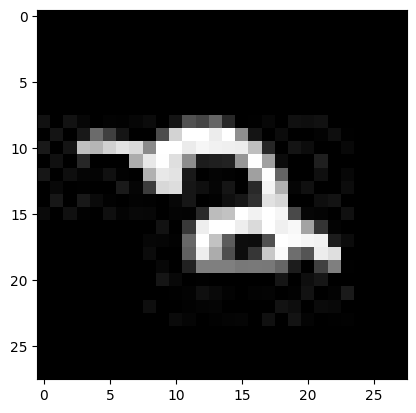

In [46]:
test_img =io.imread("C:/Users/asingh74/Desktop/DML_Projects/MNIST/Pos-Neg_Cases/neg_case/2/Two_262.jpg")
plt.imshow(test_img)
test_img = torch.from_numpy(test_img).permute (2, 0, 1)/255.0
model.eval ( )
with torch.no_grad():
    test_img = test_img.to(DEVICE)
    test_img_enc= model(test_img.unsqueeze (0))
    test_img_enc = test_img_enc.detach().cpu ().numpy ()
print(test_img_enc.shape)

In [51]:
distance ={}
for i in range(r):
    dist=euclidean_dist(test_img_enc, anc_enc_arr[i:i+1, :])
    distance[faces_list[i]] = dist
    i+=1 

In [52]:
sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
print(sorted_dist)

{'Eight_100.jpg': array([[1.40518388]]), 'Eight_103.jpg': array([[1.46574227]]), 'Eight_0.jpg': array([[1.47826292]]), 'Eight_1.jpg': array([[1.48675877]]), 'Eight_102.jpg': array([[1.48762748]]), 'Eight_10.jpg': array([[1.49148218]]), 'Eight_104.jpg': array([[1.49785417]]), 'Eight_101.jpg': array([[1.49913817]]), 'Eight_105.jpg': array([[1.50746009]]), 'Eight_106.jpg': array([[1.50798709]])}


In [49]:
dist_sort = sorted_dist.keys()
dist_sort = list(dist_sort)
print(dist_sort)

['Eight_100.jpg', 'Eight_103.jpg', 'Eight_0.jpg', 'Eight_1.jpg', 'Eight_102.jpg', 'Eight_10.jpg', 'Eight_104.jpg', 'Eight_101.jpg', 'Eight_105.jpg', 'Eight_106.jpg']


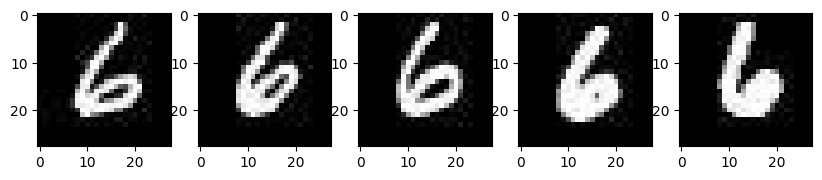

In [182]:
# Five nearest Images to Test_Img

f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(10,5))
img1 = io.imread(DATA_DIR+dist_sort[1])
img2 = io.imread(DATA_DIR+dist_sort[2])
img3 = io.imread(DATA_DIR+dist_sort[3])
img4 = io.imread(DATA_DIR+dist_sort[4])
img5 = io.imread(DATA_DIR+dist_sort[5])
img_arr=[img1, img2,img3, img4, img5]
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2 , cmap='gray')
ax3.imshow(img3 , cmap='gray')
ax4.imshow(img4 , cmap='gray')
ax5.imshow(img5 , cmap='gray')

## Accuracy Calculation using Clustering

In [13]:
train_df= pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_Training.csv')
train_df=train_df.iloc[:,1:]

In [14]:
sorted_df = train_df.sort_values(by='Label')

In [15]:
centroids_df = sorted_df.groupby('Label', as_index=False)[[ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']].mean()

In [16]:
centroids_df.head()

,Label,0,1,2,3,4,5,6,7,8,9
0,0,0.594915,0.407588,0.407084,-0.012628,-0.151039,0.136955,0.119642,0.132911,0.207072,0.435829
1,1,0.202005,0.132018,-0.185170,-0.391243,-0.599772,0.163270,-0.458250,-0.214071,-0.171263,-0.282786
2,2,-0.401080,-0.166273,-0.563110,-0.083484,0.476492,0.291781,-0.129586,0.301708,-0.121926,-0.207876
3,3,0.345021,0.177264,-0.076460,0.218681,-0.186049,-0.668827,0.145345,0.379724,-0.354152,-0.135705
4,4,0.169651,0.263164,-0.109011,0.710354,0.223329,0.272800,-0.158893,-0.421162,-0.225356,-0.048211


In [17]:
ln = X_test.shape[0]
print(ln, r)


600 1800


In [18]:
dig_list = centroids_df.iloc[:,0]
dig_list = list(dig_list)
dig_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [19]:
anc_enc_arr = centroids_df.iloc[:,1:].to_numpy()
r = anc_enc_arr.shape[0]
print(r)

10


In [258]:
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = X_test.iloc[i,1:]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    if(df_valid.iloc[i][-1] == int(nearest_img)):
        count+=1
    i+=1

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_valid.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11980\1473223027.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

In [259]:
print(count)

577


In [260]:
acc = (count/ln)*100

In [261]:
print("Accuracy is :",acc)

Accuracy is : 96.16666666666667


## Using Other distance measures

## 1. Manhattan Distance

In [55]:
pdist = nn.PairwiseDistance(p=1)

In [56]:
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = X_test.iloc[i,1:]
    img_enc = pd.DataFrame([img_enc])
    img_enc = torch.tensor(img_enc.values)
    distance ={}
    j=0
    for j in range(r):
        dist=pdist(img_enc, torch.tensor(anc_enc_arr[j:j+1, :]))
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    if(df_valid.iloc[i][-1] == int(nearest_img)):
        count+=1
    i+=1

NameError: name 'pdist' is not defined

In [41]:
print(count)

578


In [94]:
ln 

600

In [27]:
count

0

## Classwise Accuracy calculation

In [34]:
l = []
df_val_0 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Zero/Train_0.csv')
df_val_1 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/One/Train_1.csv')
df_val_2 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Two/Train_2.csv')
df_val_3 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Three/Train_3.csv')
df_val_4 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Four/Train_4.csv')
df_val_5 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Five/Train_5.csv')
df_val_6 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Six/Train_6.csv')
df_val_7 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Seven/Train_7.csv')
df_val_8 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Eight/Train_8.csv')
df_val_9 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Training/Nine/Train_9.csv')
l=[df_val_0,df_val_1,df_val_2,df_val_3,df_val_4,df_val_5,df_val_6,df_val_7,df_val_8,df_val_9]

In [35]:
Acc=[]
lx = len(l)
for x in range(0,lx):
    i=0
    j=0
    count=0
    for i in range(0, 60):
        img_enc = l[x].iloc[i,1:-1]
        img_enc = pd.DataFrame([img_enc])
        img_enc = torch.tensor(img_enc.values)
        distance ={}
        j=0
        for j in range(0,r):
            dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
            distance[dig_list[j]] = dist
            j+=1
        sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
        dist_sort = sorted_dist.keys()
        dist_sort = list(dist_sort)
        nearest_img = dist_sort[0]
        if(l[x].iloc[i][-1] == int(nearest_img)):
            count+=1
        i+=1
        a=(count/60)*100
        a = round(a, 1)
    x=x+1
    Acc.append(a)


C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\455743588.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(l[x].iloc[i][-1] == int(nearest_img)):


In [36]:
print(Acc)

[96.7, 98.3, 96.7, 93.3, 98.3, 98.3, 93.3, 93.3, 96.7, 96.7]


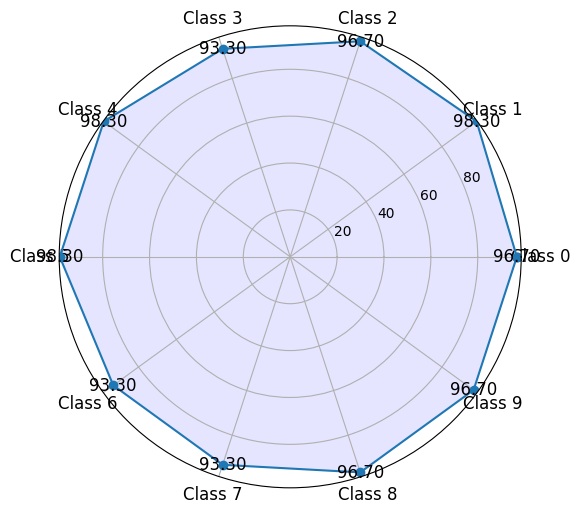

In [31]:
import numpy as np
import matplotlib.pyplot as plt


accuracies = [96.7, 98.3, 96.7, 93.3, 98.3, 98.3, 93.3, 93.3, 96.7, 96.7]


num_classes = len(accuracies)


angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()


accuracies = np.concatenate((accuracies,[accuracies[0]]))
angles += angles[:1]


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, accuracies, marker='o')
ax.fill(angles, accuracies, 'blue', alpha=0.1)


for angle, accuracy in zip(angles[:-1], accuracies[:-1]):
    ax.annotate('{:.2f}'.format(accuracy), xy=(angle, accuracy), xytext=(angle, accuracy + 0.05),
                ha='center', va='center', fontsize=12, color='black')


ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Class {}'.format(i) for i in range(num_classes)], fontsize=12)

plt.show()


## Confusion Metrics of Accuracy

In [26]:
pred=[]
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = X_test.iloc[i,1:]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    pred.append(int(nearest_img))

In [27]:
act = df_valid.iloc[:,-1]

In [28]:
pred = pd.DataFrame(pred,columns=['Label'])

In [3]:
from sklearn import metrics

In [30]:
conf_matrix = metrics.confusion_matrix(act, pred)
conf_df = pd.DataFrame(conf_matrix, index=['Actual {}'.format(i) for i in range(10)], columns=['Predicted {}'.format(i) for i in range(10)])

conf_df


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,58,0,0,1,0,0,0,0,0,1
Actual 1,0,59,0,0,0,0,0,0,0,1
Actual 2,0,0,58,0,1,0,0,1,0,0
Actual 3,0,0,0,56,0,3,0,0,1,0
Actual 4,0,0,1,0,59,0,0,0,0,0
Actual 5,0,0,0,1,0,59,0,0,0,0
Actual 6,0,0,2,0,1,1,56,0,0,0
Actual 7,0,0,1,0,0,1,0,56,2,0
Actual 8,0,0,2,0,0,0,0,0,58,0
Actual 9,0,0,0,0,1,1,0,0,0,58


## Testing Accuracy Calculation

In [59]:
import os
def get_file_names_in_folder(folder_path):
    file_names = []
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            file_names.append(file_name)
    return file_names

def get_folder_names_in_folder(folder_path):
    folder_names = []
    # List all items in the folder
    for item_name in os.listdir(folder_path):
        # Check if the path is a directory
        if os.path.isdir(os.path.join(folder_path, item_name)):
            folder_names.append(item_name)
    return folder_names

folder_path = r'C:/Users/asingh74/Desktop/DML_Projects/MNIST/DataSet/Testing'
folder_names = get_folder_names_in_folder(folder_path)

dir=[]
for folder_name in folder_names:
    dir.append(folder_name)
    
files=[]
celebs = len(dir)
for i in range(0, celebs):
    file_path = folder_path+"/"+dir[i]
    file=get_file_names_in_folder(file_path)
    for f in file:
        files.append(f)
print(len(files))

600


In [60]:
df=pd.DataFrame(files, columns=['Images'])

In [63]:
model.load_state_dict(torch.load('MNIST_Model_Final.pt'))
df_enc=get_encoding_csv(model,df['Images'])

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  1%|▊                                                                                 | 6/600 [00:01<02:14,  4.41it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  4%|███▏                                                                             | 24/600 [00:02<00:25, 22.52it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  5%|████                                                                             | 30/600 [00:02<00:20, 27.58it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  7%|█████▌                                                                           | 41/600 [00:02<00:14, 37.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


  9%|███████▏                                                                         | 53/600 [00:02<00:12, 44.15it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 11%|████████▊                                                                        | 65/600 [00:02<00:12, 44.47it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 13%|██████████▍                                                                      | 77/600 [00:03<00:10, 51.22it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 14%|███████████▏                                                                     | 83/600 [00:03<00:09, 53.57it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 16%|████████████▊                                                                    | 95/600 [00:03<00:09, 50.55it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 18%|██████████████▍                                                                 | 108/600 [00:03<00:08, 55.45it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 20%|████████████████                                                                | 120/600 [00:03<00:08, 56.35it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 22%|█████████████████▌                                                              | 132/600 [00:04<00:08, 54.01it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 24%|███████████████████▏                                                            | 144/600 [00:04<00:09, 50.56it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 25%|████████████████████                                                            | 150/600 [00:04<00:08, 50.36it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 27%|█████████████████████▋                                                          | 163/600 [00:04<00:08, 52.67it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 29%|███████████████████████▍                                                        | 176/600 [00:04<00:07, 55.07it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 31%|█████████████████████████                                                       | 188/600 [00:05<00:07, 54.90it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 33%|██████████████████████████▋                                                     | 200/600 [00:05<00:07, 56.19it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 36%|████████████████████████████▍                                                   | 213/600 [00:05<00:06, 58.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 38%|██████████████████████████████                                                  | 225/600 [00:05<00:06, 57.17it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 40%|███████████████████████████████▌                                                | 237/600 [00:06<00:06, 55.04it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 42%|█████████████████████████████████▎                                              | 250/600 [00:06<00:05, 58.42it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 44%|██████████████████████████████████▉                                             | 262/600 [00:06<00:06, 55.99it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 46%|████████████████████████████████████▋                                           | 275/600 [00:06<00:06, 53.94it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 47%|█████████████████████████████████████▍                                          | 281/600 [00:06<00:06, 51.21it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 49%|███████████████████████████████████████▏                                        | 294/600 [00:07<00:05, 54.85it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 51%|████████████████████████████████████████▉                                       | 307/600 [00:07<00:05, 55.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 53%|██████████████████████████████████████████▌                                     | 319/600 [00:07<00:05, 53.22it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 55%|████████████████████████████████████████████▎                                   | 332/600 [00:07<00:04, 54.29it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 57%|██████████████████████████████████████████████                                  | 345/600 [00:08<00:04, 55.62it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 60%|███████████████████████████████████████████████▌                                | 357/600 [00:08<00:04, 54.33it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 60%|████████████████████████████████████████████████▍                               | 363/600 [00:08<00:04, 53.52it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 63%|██████████████████████████████████████████████████▏                             | 376/600 [00:08<00:04, 54.81it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 65%|███████████████████████████████████████████████████▋                            | 388/600 [00:08<00:03, 53.08it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 66%|████████████████████████████████████████████████████▌                           | 394/600 [00:08<00:03, 52.73it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 68%|██████████████████████████████████████████████████████▏                         | 406/600 [00:09<00:03, 50.21it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 70%|███████████████████████████████████████████████████████▋                        | 418/600 [00:09<00:03, 49.60it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 72%|█████████████████████████████████████████████████████████▎                      | 430/600 [00:09<00:03, 49.55it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 74%|██████████████████████████████████████████████████████████▉                     | 442/600 [00:09<00:02, 53.18it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 75%|███████████████████████████████████████████████████████████▋                    | 448/600 [00:10<00:02, 52.72it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 76%|█████████████████████████████████████████████████████████████▏                  | 459/600 [00:10<00:03, 46.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 78%|██████████████████████████████████████████████████████████████▋                 | 470/600 [00:10<00:02, 50.68it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 80%|████████████████████████████████████████████████████████████████▎               | 482/600 [00:10<00:02, 53.50it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 81%|█████████████████████████████████████████████████████████████████               | 488/600 [00:10<00:02, 50.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 83%|██████████████████████████████████████████████████████████████████▋             | 500/600 [00:11<00:02, 47.97it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 85%|████████████████████████████████████████████████████████████████████▎           | 512/600 [00:11<00:01, 49.89it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 87%|█████████████████████████████████████████████████████████████████████▊          | 524/600 [00:11<00:01, 50.88it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 88%|██████████████████████████████████████████████████████████████████████▋         | 530/600 [00:11<00:01, 53.23it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 90%|████████████████████████████████████████████████████████████████████████▍       | 543/600 [00:11<00:01, 56.64it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 92%|██████████████████████████████████████████████████████████████████████████      | 555/600 [00:12<00:00, 53.44it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 94%|███████████████████████████████████████████████████████████████████████████▌    | 567/600 [00:12<00:00, 50.49it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 573/600 [00:12<00:00, 48.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 583/600 [00:12<00:00, 48.82it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


 99%|███████████████████████████████████████████████████████████████████████████████▏| 594/600 [00:12<00:00, 52.15it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])
A.unsqueeze (0) torch.Size([1, 3, 28, 28])


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 45.95it/s]

A.unsqueeze (0) torch.Size([1, 3, 28, 28])


In [64]:
df_enc.to_csv("Embeddings_Testing.csv", index=False)

In [21]:
df_train = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_Training.csv')
df_valid = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_validation.csv')
df_test = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/Embeddings_Testing.csv')

In [139]:
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = df_test.iloc[i,1:-1]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    if(df_test.iloc[i][-1] == int(nearest_img)):
        count+=1
    i+=1

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] == int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\1350584568.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

In [140]:
print(count)

576


In [141]:
print((count/ln)*100)

96.0


## Classwise Accuracy for Test Images

In [125]:
t = []
df_test_0 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Zero/Test_0.csv')
df_test_1 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/One/Test_1.csv')
df_test_2 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Two/Test_2.csv')
df_test_3 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Three/Test_3.csv')
df_test_4 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Four/Test_4.csv')
df_test_5 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Five/Test_5.csv')
df_test_6 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Six/Test_6.csv')
df_test_7 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Seven/Test_7.csv')
df_test_8 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Eight/Test_8.csv')
df_test_9 = pd.read_csv('C:/Users/asingh74/Desktop/DML_Projects/MNIST/ClassWise Accuracy/Testing/Nine/Test_9.csv')
t=[df_test_0,df_test_1,df_test_2,df_test_3,df_test_4,df_test_5,df_test_6,df_test_7,df_test_8,df_test_9]

In [126]:
for u in range(10):
    print(t[u].shape)

(60, 12)
(60, 12)
(60, 12)
(60, 12)
(60, 12)
(60, 12)
(60, 12)
(60, 12)
(60, 12)
(60, 12)


In [129]:
Acc_t=[]
lx = len(t)
x=0
for x in range(0,lx):
    i=0
    j=0
    count=0
    for i in range(0, 60):
        img_enc = t[x].iloc[i,1:-1]
        img_enc = pd.DataFrame([img_enc])
        img_enc = torch.tensor(img_enc.values)
        distance ={}
        j=0
        for j in range(0,r):
            dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
            distance[dig_list[j]] = dist
            j+=1
        sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
        dist_sort = sorted_dist.keys()
        dist_sort = list(dist_sort)
        nearest_img = dist_sort[0]
        if(t[x].iloc[i][-1] == int(nearest_img)):
            count+=1
        i+=1
        a=(count/60)*100
        a = round(a, 1)
    x=x+1
    Acc_t.append(a)

C:\Users\asingh74\AppData\Local\Temp\ipykernel_11044\2417816303.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(t[x].iloc[i][-1] == int(nearest_img)):


In [130]:
print(Acc_t)

[100.0, 96.7, 96.7, 98.3, 96.7, 96.7, 100.0, 86.7, 96.7, 91.7]


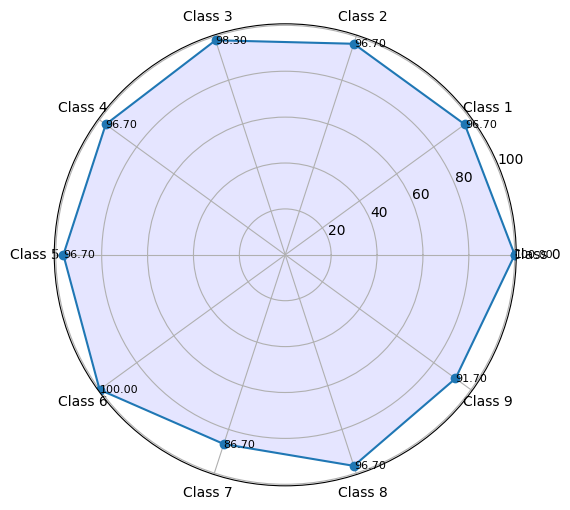

In [137]:
import numpy as np
import matplotlib.pyplot as plt


accuracies = Acc_t


num_classes = len(accuracies)


angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()


accuracies = np.concatenate((accuracies,[accuracies[0]]))
angles += angles[:1]


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, accuracies, marker='o')
ax.fill(angles, accuracies, 'blue', alpha=0.1)


for angle, accuracy in zip(angles[:-1], accuracies[:-1]):
    ax.annotate('{:.2f}'.format(accuracy), xy=(angle, accuracy), xytext=(angle, accuracy + 0.05),
                ha='left', va='center', fontsize=8, color='black')


ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Class {}'.format(i) for i in range(num_classes)], fontsize=10)

plt.show()


## Confusion Matrix for Testing Data

In [132]:

pred=[]
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = df_test.iloc[i,1:-1]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    if (nearest_img == dist_sort[0]):
        pred.append(int(nearest_img))

In [133]:
act = df_test.iloc[:,-1]

In [134]:
pred = pd.DataFrame(pred,columns=['Label'])

In [138]:

conf_matrix = metrics.confusion_matrix(act, pred)
conf_df = pd.DataFrame(conf_matrix, index=['Actual {}'.format(i) for i in range(10)], columns=['Predicted {}'.format(i) for i in range(10)])

conf_df




,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,60,0,0,0,0,0,0,0,0,0
Actual 1,0,58,1,0,0,0,0,0,1,0
Actual 2,0,0,58,1,0,1,0,0,0,0
Actual 3,0,0,0,59,0,1,0,0,0,0
Actual 4,0,1,0,0,58,0,1,0,0,0
Actual 5,0,0,0,0,0,58,2,0,0,0
Actual 6,0,0,0,0,0,0,60,0,0,0
Actual 7,1,1,1,0,1,0,0,52,1,3
Actual 8,0,0,1,0,1,0,0,0,58,0
Actual 9,1,0,0,1,0,0,0,2,1,55


In [27]:
got_what = []
neg_l = []
i=0
j=0
count=0
for i in range(0, ln):
    img_enc = df_test.iloc[i,1:-1]
    img_enc = pd.DataFrame([img_enc])
    distance ={}
    j=0
    for j in range(r):
        dist=euclidean_dist(img_enc, anc_enc_arr[j:j+1, :])
        distance[dig_list[j]] = dist
        j+=1
    sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))
    dist_sort = sorted_dist.keys()
    dist_sort = list(dist_sort)
    nearest_img = dist_sort[0]
    if(df_test.iloc[i][-1] != int(nearest_img)):
        got_what.append(dist_sort[0])
        neg_l.append(df_test.iloc[i][0])
    i+=1

C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neg_l.append(df_test.iloc[i][0])
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test

C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df_test.iloc[i][-1] != int(nearest_img)):
C:\Users\asingh74\AppData\Local\Temp\ipykernel_6336\2935955477.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [28]:
neg_l

['Eight_258.jpg',
 'Eight_291.jpg',
 'Five_283.jpg',
 'Five_287.jpg',
 'Four_247.jpg',
 'Four_252.jpg',
 'Nine_247.jpg',
 'Nine_262.jpg',
 'Nine_265.jpg',
 'Nine_272.jpg',
 'Nine_276.jpg',
 'One_261.jpg',
 'One_293.jpg',
 'Seven_243.jpg',
 'Seven_244.jpg',
 'Seven_259.jpg',
 'Seven_260.jpg',
 'Seven_266.jpg',
 'Seven_283.jpg',
 'Seven_285.jpg',
 'Seven_292.jpg',
 'Three_298.jpg',
 'Two_262.jpg',
 'Two_278.jpg']

In [29]:
got_what

[4, 2, 6, 6, 1, 6, 8, 0, 7, 7, 3, 2, 8, 4, 9, 8, 1, 9, 2, 0, 9, 5, 5, 3]

## Taking Corner Images

## Case 3:

(1, 10)


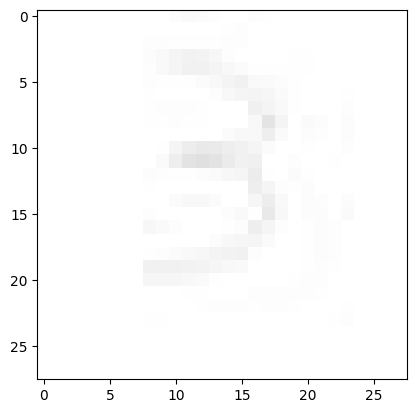

In [153]:
test_img2 = io.imread("C:/Users/asingh74/Desktop/DML_Projects/MNIST/Corner Cases/3.jpg")
plt.imshow(test_img2)
test_img2 = torch.from_numpy(test_img2).permute (2, 0, 1)/255.0
model.eval ( )
with torch.no_grad():
    test_img2 = test_img2.to(DEVICE)
    test_img2_enc= model (test_img2.unsqueeze (0))
    test_img2_enc = test_img2_enc.detach().cpu ().numpy ()
print(test_img2_enc.shape)

In [154]:
distance ={}
for i in range(r):
    dist=euclidean_dist(test_img2_enc, anc_enc_arr[i:i+1, :])
    distance[faces_list[i]] = dist
    i+=1 

In [155]:
print(distance)

{'Eight_0.jpg': array([[1.49759106]]), 'Eight_1.jpg': array([[1.49105439]]), 'Eight_10.jpg': array([[1.49315695]]), 'Eight_100.jpg': array([[1.57644575]]), 'Eight_101.jpg': array([[1.47781686]]), 'Eight_102.jpg': array([[1.49475057]]), 'Eight_103.jpg': array([[1.51957191]]), 'Eight_104.jpg': array([[1.47759694]]), 'Eight_105.jpg': array([[1.47571022]]), 'Eight_106.jpg': array([[1.43244544]]), 'Eight_107.jpg': array([[1.49947994]]), 'Eight_108.jpg': array([[1.49863418]]), 'Eight_109.jpg': array([[1.49622115]]), 'Eight_11.jpg': array([[1.50317576]]), 'Eight_110.jpg': array([[1.53151027]]), 'Eight_111.jpg': array([[1.48362969]]), 'Eight_112.jpg': array([[1.4995577]]), 'Eight_113.jpg': array([[1.49466247]]), 'Eight_114.jpg': array([[1.48776154]]), 'Eight_115.jpg': array([[1.50739513]]), 'Eight_116.jpg': array([[1.53017874]]), 'Eight_117.jpg': array([[1.52817929]]), 'Eight_118.jpg': array([[1.50211319]]), 'Eight_119.jpg': array([[1.47068556]]), 'Eight_12.jpg': array([[1.51040503]]), 'Eight_

In [156]:
sorted_dist = dict(sorted(distance.items(), key=lambda item: item[1]))

In [157]:
dist_sort = sorted_dist.keys()
dist_sort = list(dist_sort)
print(dist_sort)

['Three_66.jpg', 'Seven_123.jpg', 'Three_124.jpg', 'Three_99.jpg', 'Three_68.jpg', 'Seven_166.jpg', 'Zero_86.jpg', 'Zero_26.jpg', 'Seven_94.jpg', 'Three_38.jpg', 'Three_157.jpg', 'Three_40.jpg', 'Zero_148.jpg', 'Three_134.jpg', 'Seven_4.jpg', 'Three_165.jpg', 'Three_17.jpg', 'Three_70.jpg', 'Seven_9.jpg', 'Seven_78.jpg', 'Three_127.jpg', 'Three_25.jpg', 'Three_104.jpg', 'Zero_88.jpg', 'Three_128.jpg', 'Three_80.jpg', 'Seven_134.jpg', 'Three_78.jpg', 'Three_116.jpg', 'Zero_11.jpg', 'Three_100.jpg', 'Seven_102.jpg', 'Seven_58.jpg', 'Three_11.jpg', 'Three_169.jpg', 'Three_1.jpg', 'Three_24.jpg', 'Three_35.jpg', 'Three_125.jpg', 'Three_178.jpg', 'Zero_84.jpg', 'Zero_101.jpg', 'Seven_24.jpg', 'Seven_117.jpg', 'Seven_110.jpg', 'Three_37.jpg', 'Three_7.jpg', 'Zero_119.jpg', 'Three_164.jpg', 'Three_14.jpg', 'Three_105.jpg', 'Three_176.jpg', 'Three_120.jpg', 'Seven_50.jpg', 'Seven_169.jpg', 'Seven_7.jpg', 'Zero_132.jpg', 'Three_121.jpg', 'Three_173.jpg', 'Seven_31.jpg', 'Seven_113.jpg', 'Three_

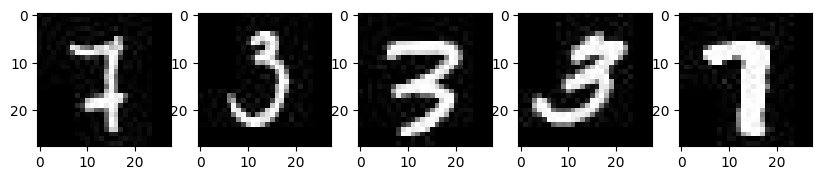

In [158]:
f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(10,5))
img1 = io.imread(DATA_DIR+dist_sort[1])
img2 = io.imread(DATA_DIR+dist_sort[2])
img3 = io.imread(DATA_DIR+dist_sort[3])
img4 = io.imread(DATA_DIR+dist_sort[4])
img5 = io.imread(DATA_DIR+dist_sort[5])
img_arr=[img1, img2,img3, img4, img5]
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2 , cmap='gray')
ax3.imshow(img3 , cmap='gray')
ax4.imshow(img4 , cmap='gray')
ax5.imshow(img5 , cmap='gray')

In [71]:
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()